In [31]:
import pandas as pd
from pathlib import Path

In [32]:
ecg_data_dir = Path('../data/raw/xml')

In [33]:
len(list(ecg_data_dir.glob('*.xml')))

43511

In [34]:
# xml_file_path = list(ecg_data_dir.glob('*.xml'))[0]
xml_file_path = '../data/raw/xml/MUSE_20231122_211154_57000.xml'

In [35]:
import os
import csv
import array
import base64
import xmltodict

import numpy as np

__author__ = "Will Hewitt"
__credits__ = ["Will Hewitt"]
__version__ = "1.0.0"
__maintainer__ = "Will Hewitt"
__email__ = "me@hewittwill.com"
__status__ = "Development"

class ECGXMLReader:
    """ Extract voltage data from a ECG XML file """
    def __init__(self, path, augmentLeads=False):
        try: 
            with open(path, 'rb') as xml:
                self.ECG = xmltodict.parse(xml.read().decode('ISO-8859-1'))
            
            self.augmentLeads           = augmentLeads
            self.path                   = path

            self.PatientDemographics    = self.ECG['RestingECG']['PatientDemographics']
            self.TestDemographics       = self.ECG['RestingECG']['TestDemographics']
            self.RestingECGMeasurements = self.ECG['RestingECG']['RestingECGMeasurements']
            self.Waveforms              = self.ECG['RestingECG']['Waveform'][1]

            self.LeadVoltages           = self.makeLeadVoltages()
        
        except Exception as e:
            print(str(e))
    
    def makeLeadVoltages(self):

        num_leads = 0

        leads = {}

        for lead in self.Waveforms['LeadData']:
            num_leads += 1
            
            lead_data = lead['WaveFormData']
            lead_b64  = base64.b64decode(lead_data)
            lead_vals = np.array(array.array('h', lead_b64))

            leads[ lead['LeadID'] ] = lead_vals
        
        if num_leads == 8 and self.augmentLeads:

            leads['III'] = np.subtract(leads['II'], leads['I'])
            leads['aVR'] = np.add(leads['I'], leads['II'])*(-0.5)
            leads['aVL'] = np.subtract(leads['I'], 0.5*leads['II'])
            leads['aVF'] = np.subtract(leads['II'], 0.5*leads['I'])
        
        return leads

    def getLeadVoltages(self, LeadID):
        return self.LeadVoltages[LeadID]
    
    def getAllVoltages(self):
        return self.LeadVoltages

In [36]:
try:
    ecg_reader = ECGXMLReader(xml_file_path)
except Exception as e:
    print(f"Error during initialization: {str(e)}")

all_voltages = ecg_reader.getAllVoltages()

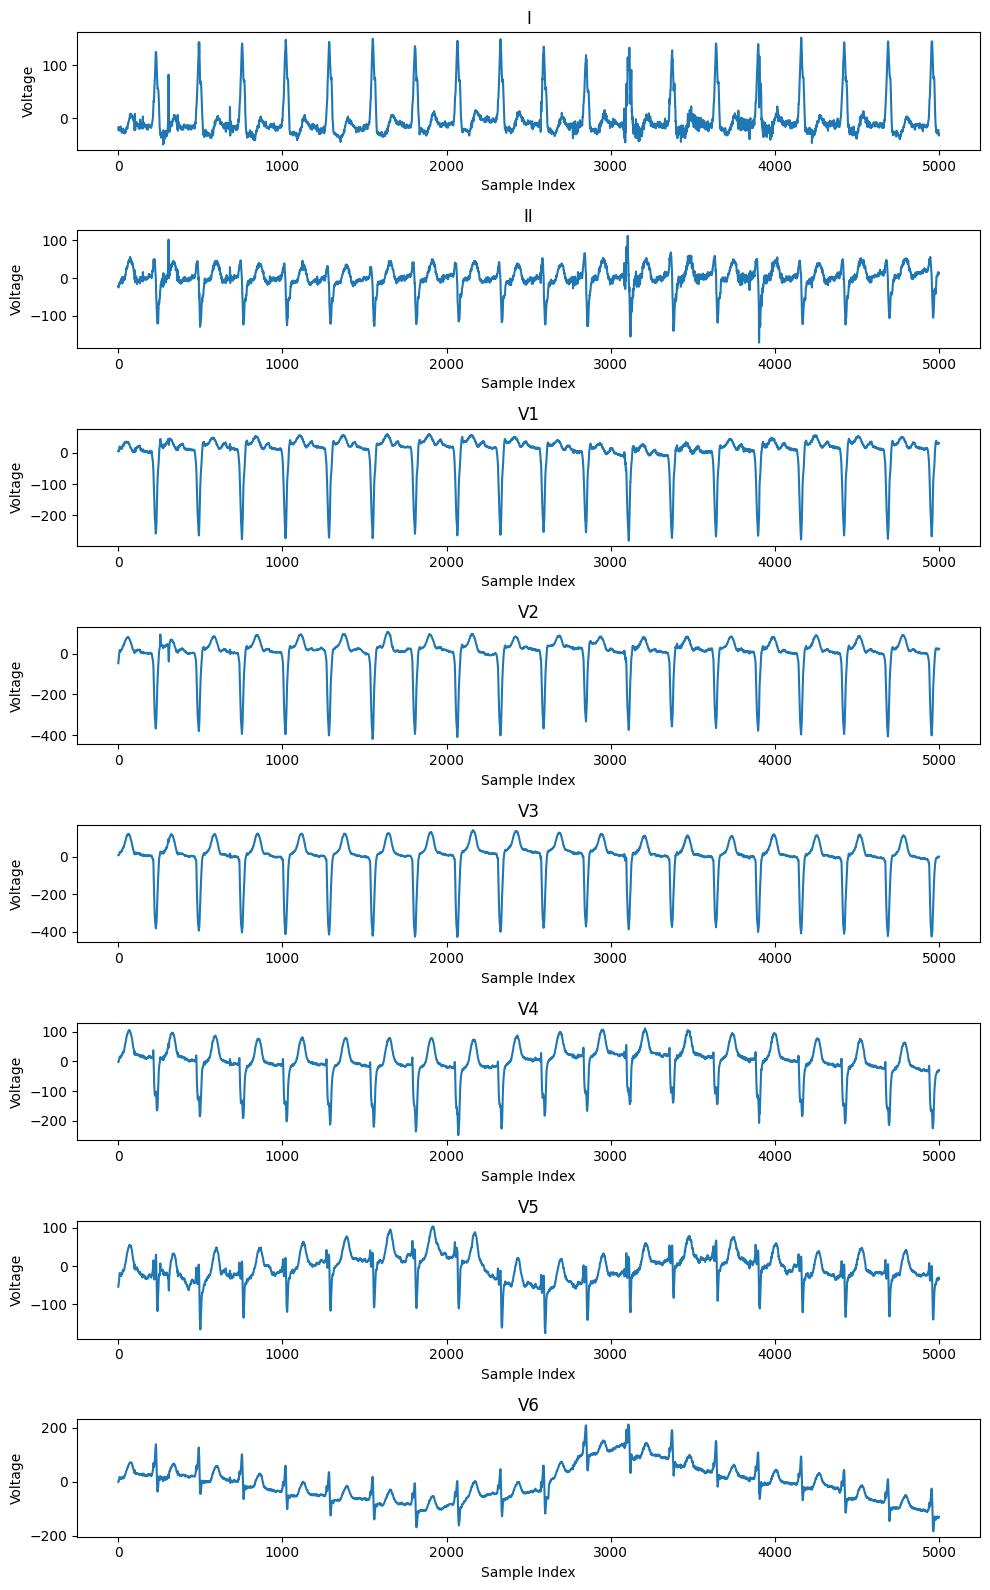

In [37]:
import matplotlib.pyplot as plt

# Number of leads
num_leads = len(all_voltages)

# Set up subplots
fig, axs = plt.subplots(num_leads, 1, figsize=(10, 2*num_leads))

# Plot each lead in a separate subplot
for i, (lead_name, lead_data) in enumerate(all_voltages.items()):
    axs[i].plot(lead_data)
    axs[i].set_title(lead_name)
    axs[i].set_xlabel('Sample Index')
    axs[i].set_ylabel('Voltage')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
# import matplotlib.pyplot as plt
# # Plot each lead
# for lead_name, lead_data in all_voltages.items():
#     plt.plot(lead_data, label=lead_name)

# # Add labels and legend
# plt.xlabel('Sample Index')
# plt.ylabel('Voltage')
# plt.title('ECG Leads')
# plt.legend()

# # Show the plot
# plt.show()

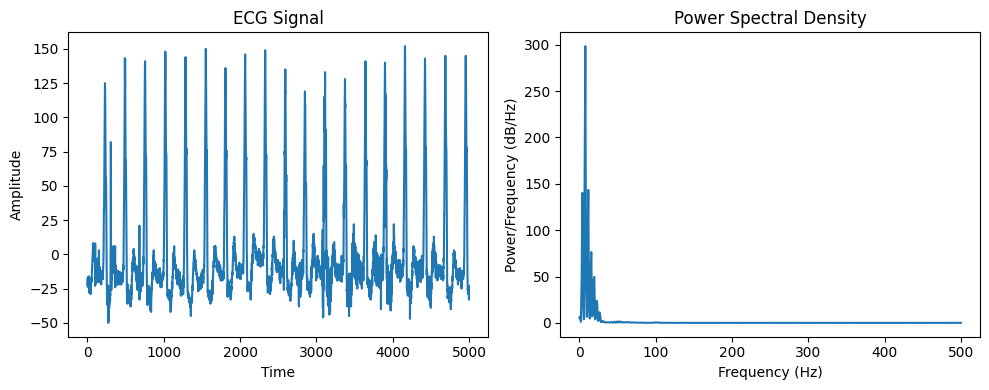

In [42]:
import xmltodict
import base64
import array
import matplotlib.pyplot as plt
import numpy as np
import struct
from matplotlib.mlab import psd

with open(xml_file_path, 'r') as file:
        # Read XML content from the file
        xml_content = file.read()
        # Parse XML to dictionary
        data_dict = xmltodict.parse(xml_content)
        b64 = data_dict['RestingECG']['Waveform'][1]['LeadData'][0]['WaveFormData']
        # print(b64)
        decoded_bytes = base64.b64decode(b64)
        # Assuming the array is of floating-point numbers, use the 'd' type code
        float_array = struct.unpack(f'{len(decoded_bytes)//2}h', decoded_bytes)
        time = np.arange(0, len(float_array), 1)
        
        # Plot the ECG signal
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(time, float_array)
        plt.title('ECG Signal')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

        # Compute and plot the PSD
        plt.subplot(1, 2, 2)
        power, frequencies = psd(float_array, NFFT=1024, Fs=1000)
        # plt.plot(frequencies, 10 * np.log10(power))
        plt.plot(frequencies, power)
        plt.title('Power Spectral Density')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency (dB/Hz)')

        plt.tight_layout()
        plt.show()

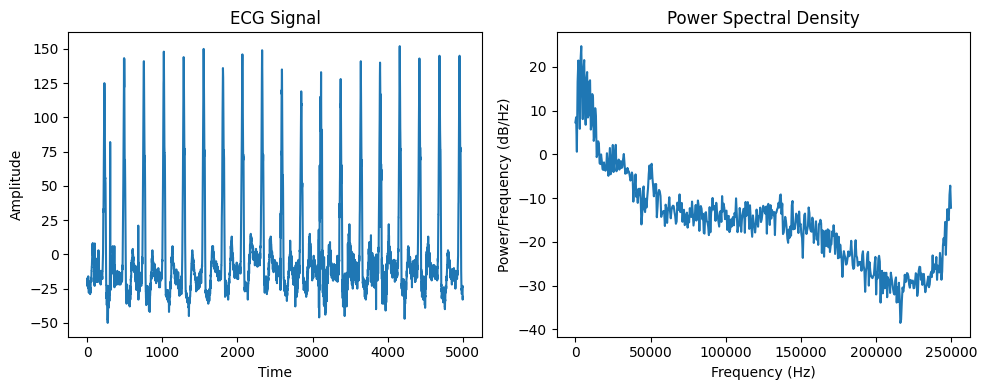

In [40]:
import xmltodict
import base64
import array
import matplotlib.pyplot as plt
import numpy as np
import struct
from matplotlib.mlab import psd

with open(xml_file_path, 'r') as file:
    # Read XML content from the file
    xml_content = file.read()
    # Parse XML to dictionary
    data_dict = xmltodict.parse(xml_content)
    b64 = data_dict['RestingECG']['Waveform'][1]['LeadData'][0]['WaveFormData']
    decoded_bytes = base64.b64decode(b64)
    # Assuming the array is of floating-point numbers, use the 'd' type code
    float_array = struct.unpack(f'{len(decoded_bytes)//2}h', decoded_bytes)
    time = np.arange(0, len(float_array), 1)

    # Plot the ECG signal
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(time, float_array)
    plt.title('ECG Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Compute and plot the PSD
    plt.subplot(1, 2, 2)
    # Specify the correct sampling frequency (Fs)
    Fs = 1000  # Replace 1000 with your actual sampling frequency
    power, frequencies = psd(float_array, NFFT=1024, Fs=Fs)
    plt.plot(frequencies * Fs / 2, 10 * np.log10(power))  # Adjust the frequency axis
    plt.title('Power Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')

    plt.tight_layout()
    plt.show()


In [25]:
import xmltodict
import json
import base64
import array
import matplotlib.pyplot as plt
import numpy as np
import struct
from matplotlib.mlab import psd
from biosppy.signals import ecg

xml_file_path = file_path

with open(xml_file_path, 'r') as file:
    # Read XML content from the file
    xml_content = file.read()
    # Parse XML to dictionary
    data_dict = xmltodict.parse(xml_content)
    b64 = data_dict['RestingECG']['Waveform'][1]['LeadData'][0]['WaveFormData']
    # print(b64)
    decoded_bytes = base64.b64decode(b64)
    # Assuming the array is of floating-point numbers, use the 'h' type code
    float_array = np.array(struct.unpack(f'{len(decoded_bytes)//2}h', decoded_bytes))
    time = np.arange(0, len(float_array), 1)

    # Remove baseline wander using biosppy
    order = 3  # Adjust the filter order as needed
    sampling_rate = 1000  # Adjust the sampling rate as needed
    filtered, _, _ = ecg.st.filter_signal(signal=float_array, sampling_rate=sampling_rate, order=order)

    # Plot the original and filtered ECG signal
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 2, 1)
    plt.plot(time, float_array)
    plt.title('Original ECG Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(2, 2, 2)
    plt.plot(time, filtered)
    plt.title('Filtered ECG Signal (Baseline Wander Removed)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Compute and plot the PSD for the original signal
    plt.subplot(2, 2, 3)
    power, frequencies = psd(float_array, NFFT=1024, Fs=sampling_rate)
    plt.plot(frequencies, 10 * np.log10(power))
    plt.title('Power Spectral Density (Original Signal)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')

    # Compute and plot the PSD for the filtered signal
    plt.subplot(2, 2, 4)
    power, frequencies = psd(filtered, NFFT=1024, Fs=sampling_rate)
    plt.plot(frequencies, 10 * np.log10(power))
    plt.title('Power Spectral Density (Filtered Signal)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')

    plt.tight_layout()
    plt.show()

TypeError: Please specify the cutoff frequency.

In [46]:
from pathlib import Path

input_path = Path('..') / '..' / 'data' / 'processed' / 'npy' / 'MUSE_20231122_211154_57000.npy'
print(input_path.parts)

# Remove the '../../' components
removed_dots_path = Path(*input_path.parts[2:])

print(removed_dots_path)


('..', '..', 'data', 'processed', 'npy', 'MUSE_20231122_211154_57000.npy')
data\processed\npy\MUSE_20231122_211154_57000.npy
